<a href="https://colab.research.google.com/github/AvishneelNarayan/ADS2002-anar0025/blob/main/NN_Regression_MPG_2024%20Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression using Neural Networks

In the previous notebooks on neural networks we have considered classification problems. Regression problems, where the output is a continuous value, can also be handled using neural networks. To demonstrate this we will use the classic [Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg) to build a model to predict the fuel efficiency of 1970s and early 1980s automobiles. This datasets describes fuel efficiency of many cars from that period. This description includes attributes such as: engine cylinders, engine displacement, horsepower, and weight.

We will show how linear regression can be implemented using neural networks, and then consider some simple nonlinear regression models.

## Contents

* Imports
* The Auto MPG Dataset
* Linear Regression
* Nonlinear Regression
* Model Performance
* Exercises

## Imports

First, import the standard libraries. If you are running this on Google Colab, and `seaborn` cannot be found, then uncomment the following cell.

In [2]:
# !pip install -q seaborn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

We import `tensorflow` and `keras`, the package `layers` for setting up sequential models and a function for normalizing data.

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization


## The Auto MPG dataset


We first download and import the dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/) using pandas. The names can be found in the file [auto-mpg.names](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names).

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
df.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
86,14.0,8,304.0,150.0,3672.0,11.5,73,1
366,17.6,6,225.0,85.0,3465.0,16.6,81,1
198,33.0,4,91.0,53.0,1795.0,17.4,76,3
233,29.0,4,97.0,78.0,1940.0,14.5,77,2
375,36.0,4,105.0,74.0,1980.0,15.3,82,2


First we check for missing values, which are denoted by `?` in the file, and which the import statement has converted to NaN.

In [7]:
df.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


Drop those rows to keep this simple.

In [8]:
df.dropna(inplace=True)

The `"Origin"` column is categorical, not numeric. So we first use a dictionary to convert it to categorical data and then one-hot encode with `pd.get_dummies`.

In [9]:
df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='', dtype=int)
df.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
324,40.8,4,85.0,65.0,2110.0,19.2,80,0,1,0
90,12.0,8,429.0,198.0,4952.0,11.5,73,0,0,1
135,18.0,6,225.0,105.0,3613.0,16.5,74,0,0,1
34,16.0,6,225.0,105.0,3439.0,15.5,71,0,0,1
138,14.0,8,318.0,150.0,4457.0,13.5,74,0,0,1


We can view the statistics, to see the range of each variable.

In [11]:
pd.set_option("display.precision", 2)
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.0,392.00
mean,23.45,5.47,194.41,104.47,2977.58,15.54,75.98,0.17,0.2,0.62
std,7.81,1.71,104.64,38.49,849.40,2.76,3.68,0.38,0.4,0.48
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,0.00,0.0,0.00
25%,17.00,4.00,105.00,75.00,2225.25,13.78,73.00,0.00,0.0,0.00
50%,22.75,4.00,151.00,93.50,2803.50,15.50,76.00,0.00,0.0,1.00
75%,29.00,8.00,275.75,126.00,3614.75,17.02,79.00,0.00,0.0,1.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,1.00,1.0,1.00


We can investigate the correlation between variables. The fuel efficiency (MPG) is highly correlated with the variables `Cylinders`, `Displacement`, `Horsepower` and `Weight`, and the correlation between these variables is very high.

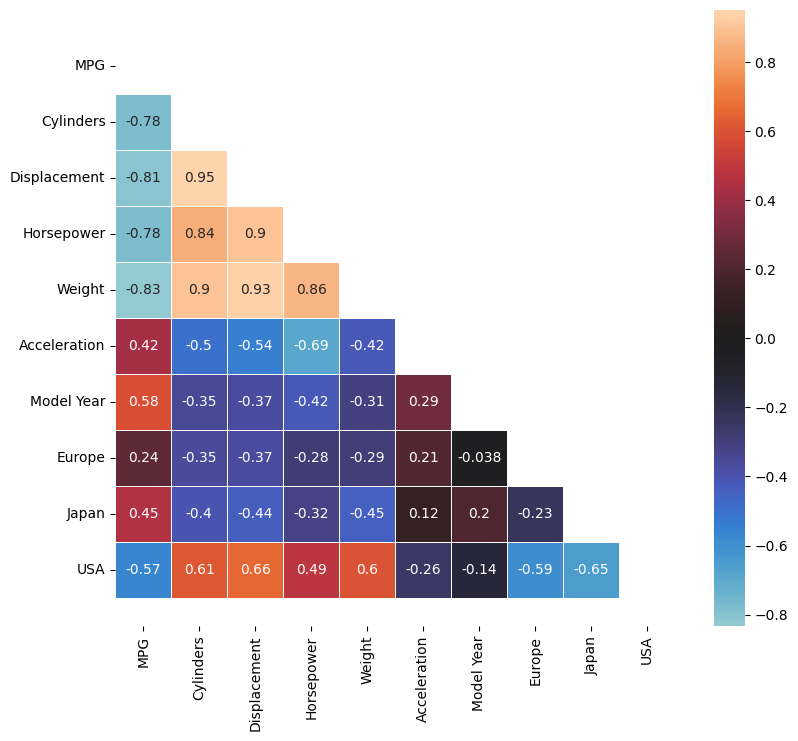

In [12]:
corrs = df.corr() # calculate the correlation table
# as this is a symmetric table,
# set up a mask so that we only plot values below the main diagonal
mask = np.triu(np.ones_like(corrs, dtype=bool))
f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
# plot the correlations as a seaborn heatmap, with a colourbar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# do some fiddling so that the top and bottom are not obscured
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

`sns.pairplot()` can be used to view the relationship between different features. What we now want to do is create a model which determines the fuel efficiency (MPG) as a function of the other features. It appears that fuel efficiency is approximately inversely proportional to the other variables.

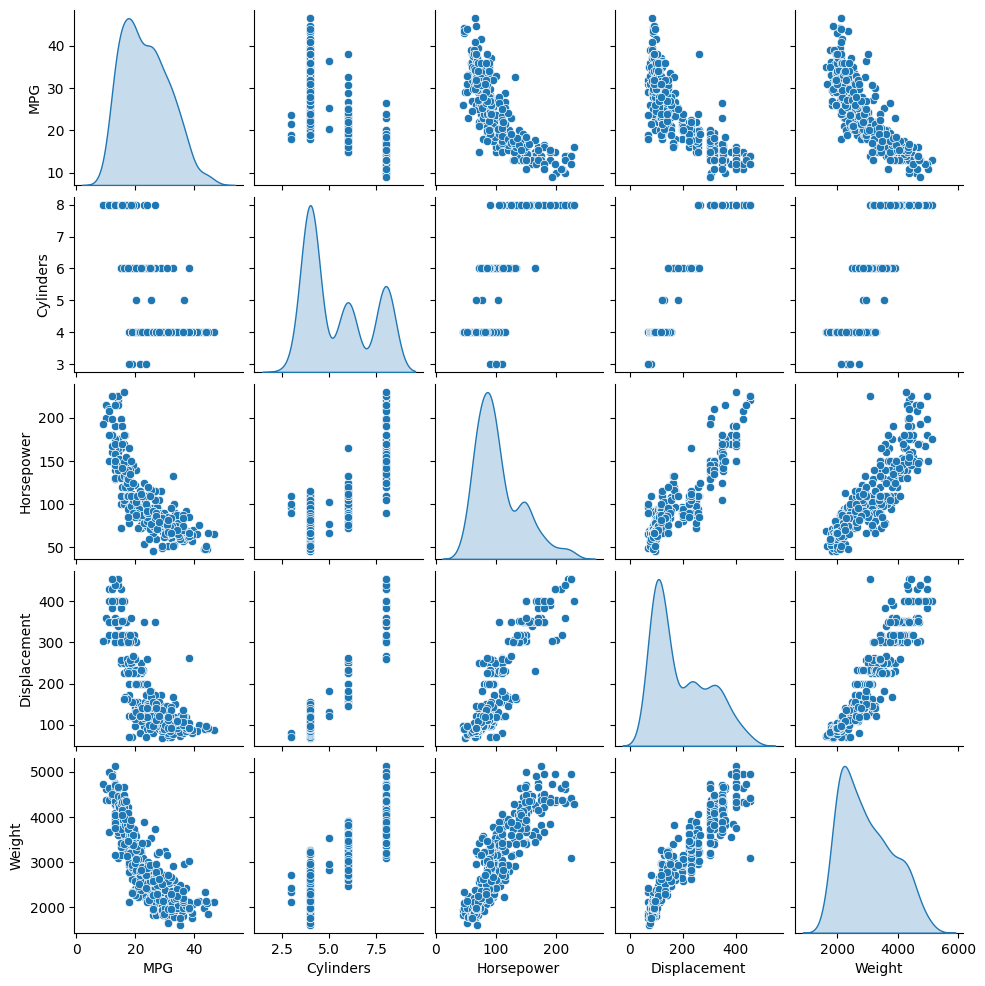

In [13]:
sns.pairplot(df[['MPG', 'Cylinders', 'Horsepower', 'Displacement', 'Weight']],
             diag_kind='kde', height=2)

Since we want to predict `MPG`, this is our label, and the other variables are features. We can separate the data into the label and features, and then split both sets into testing and training sets.

In [14]:
from sklearn.model_selection import train_test_split

features = df.drop(['MPG'], axis=1)
labels = df['MPG']

X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.2,
                                                    random_state=42)

In the table of statistics it is apparent that the values of the features are widely distributed.

In [15]:
pd.set_option("display.precision", 2)
X_train.describe().loc[['mean', 'std']]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
mean,5.48,195.52,104.59,2986.12,15.54,76.21,0.15,0.2,0.65
std,1.70,103.77,38.28,841.13,2.82,3.63,0.36,0.4,0.48


As with classification with neural networks, it is best practice to normalize features that use different scales and ranges. This ensures that techniques such as regularization, which we will consider later, can be applied uniformly.

There is no advantage to normalizing the one-hot features, it is done here for simplicity.

Previously we have used the `mean` and `std` to normalize the variables. Here we will use `keras` `Normalization` layer to build the preprocessing into the model.

The first step is to create the layer. `axis=-1` states to apply the normalization to the last dimension.

In [16]:
normalizer = Normalization(axis=-1)

Then `.adapt()` it to the data, which calculates the mean and variance, and stores them in the layer.

In [17]:
normalizer.adapt(np.array(X_train))

In [18]:
print(normalizer.mean.numpy())

[[5.48242807e+00 1.95517578e+02 1.04594246e+02 2.98612451e+03
  1.55440893e+01 7.62076645e+01 1.53354630e-01 2.01277956e-01
  6.45367384e-01]]


When the layer is called it returns the input data, with each feature independently normalized.

In [19]:
firstrow = np.array(X_train[:1])

print('First example:', firstrow)
print('Normalized:', normalizer(firstrow).numpy())

First example: [[6.00e+00 2.25e+02 1.10e+02 3.62e+03 1.87e+01 7.80e+01 0.00e+00 0.00e+00
  1.00e+00]]
Normalized: [[ 0.30486158  0.2845775   0.14142871  0.75480306  1.1217592   0.4945284
  -0.42559615 -0.50199604  0.74128604]]


## Linear regression



Before building a nonlinear neural network model, we will build a model which implements linear regression. This corresponds to a single perceptron with a continuous output.

First we create a convenience function to build and compile a simple sequential neural network. This is essentially the same as the models we have previously considered for classification, except the last layer is a `Dense` layer, with a single continuous output, and the loss function is the mean absolute error.

For this models we can specify different inputs using `norm`, the number of hidden layers and the neurons in each of these layers, the activation function and the learning rate used by SGD.

In [20]:
def build_model_regress(norm, n_hidden=1, n_neurons=30, regress_activation="relu",
                            learning_rate=0.01):
  """Build and compile a simple sequential model with n_hidden
  layers and n_neurons in each layer."""

  model = keras.models.Sequential()
  model.add(norm)
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation=regress_activation))
  model.add(keras.layers.Dense(1))

  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='mean_absolute_error', optimizer=optimizer)

  return model

We start by creating a linear regression model which takes the input `Horsepower` and aims to predict `MPG`.

For our default model we first need to create the horsepower `Normalization` layer. This just corresponds to creating an array with the `Horsepower` from the training set, initializing the normalization routine so that the input shape is a single vector (one feature) and then adapting the normalizer to calculate the mean and standard deviation of `Horsepower`.

In [21]:
horsepower = np.array(X_train['Horsepower'])

# horsepower_normalizer = Normalization(input_shape=[1,], axis=None)
horsepower_normalizer = Normalization(axis=None)
horsepower_normalizer.adapt(horsepower)

This layer then can be used as the model input. Since this is linear regression, we want no hidden layers and can set the number of neurons to 0. We can then output a summary of the model.

In [22]:
horsepower_model = build_model_regress(horsepower_normalizer, n_hidden=0,
                                 n_neurons=0, learning_rate=0.03)

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (313)                       │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (16.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3 (16.00 B)

Now the model is configured, we use `Model.fit()` to train the model. Here we use 80% of the data for training and 20% for validation. The evolution of the metrics for the model are stored in `history`.

In [23]:
%%time
history = horsepower_model.fit(
    X_train['Horsepower'], y_train,
    epochs=200,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 14.7 s, sys: 611 ms, total: 15.3 s
Wall time: 23.1 s


We can create a simple function for plotting the history of the model.

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

For this model the training loss and the validation loss decreases steadily, with the training loss always being less than the validation loss, which is to be expected.

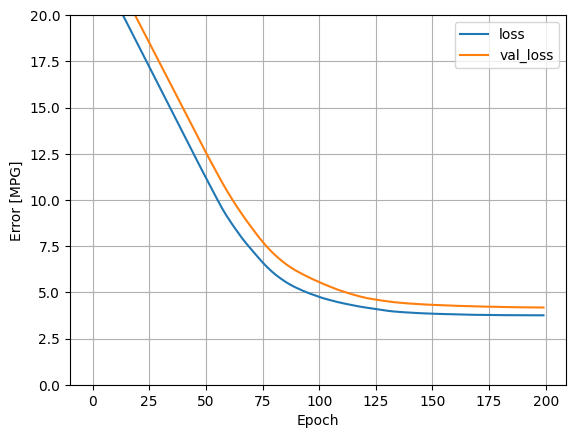

In [25]:
plot_loss(history)

We evaluate the results and store them in a structure for comparison with the other models.

In [26]:
test_results = {}

test_results['lin_horsepower_model'] = horsepower_model.evaluate(
    X_test['Horsepower'],
    y_test, verbose=0)

Since this is a single variable linear regression the output corresponds to a linear relationship, and we can compare the model predictions against the actual value.

In [27]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


We define another convenience function for comparing the predictions.

In [28]:
def plot_horsepower(x, y):
  plt.scatter(X_train['Horsepower'], y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

The predictions are reasonable for mid-range horsepower, but fail at the upper and lower limits.

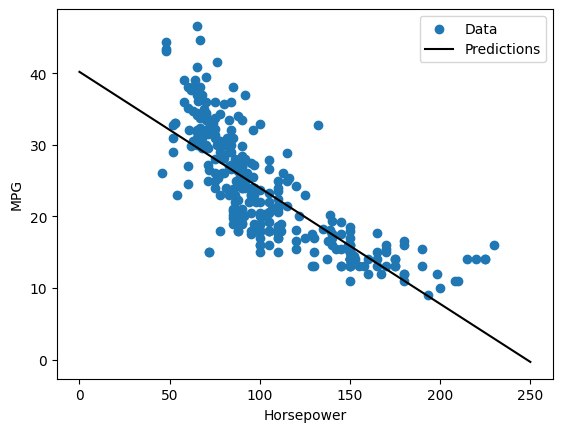

In [29]:
plot_horsepower(x,y)

To implement multi-dimensional linear regression, we now just need to input the normalization layer which was defined earlier for the whole data set. Now the input shape corresponds to nine features.

In [30]:
linear_model = build_model_regress(normalizer, n_hidden=0, n_neurons=0,
                                 learning_rate=0.03)

linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (313, 9)                    │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

We can now `fit` the model using the full training dataset.

In [31]:
%%time
history = linear_model.fit(
    X_train, y_train,
    epochs=200,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 12 s, sys: 518 ms, total: 12.5 s
Wall time: 14.6 s


Plotting the history demonstrates that using all the inputs achieves a much lower training and validation error than the `horsepower` model.

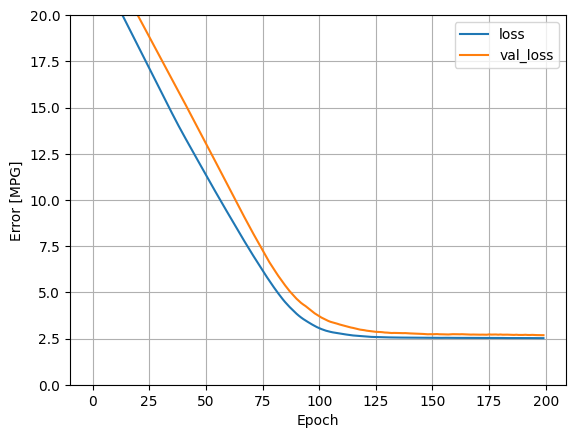

In [32]:
plot_loss(history)

We collect the results of the test set, for later comparison.

In [33]:
test_results['lin_model'] = linear_model.evaluate(
    X_test, y_test, verbose=0)

## Nonlinear regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input Neural Network models. The code is essentially the same except the model is expanded to include hidden  nonlinear layers.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.


We start with a model for the single input "Horsepower". The only difference is the number of hidden layers, and the number of neurons in these layers. However, there are now significantly more trainable parameters.

In [34]:
nn_horsepower_model = build_model_regress(horsepower_normalizer, n_hidden=2,
                                     n_neurons=64, learning_rate=0.03)

nn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (16.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3 (16.00 B)

Training of the model is the same as before.

In [35]:
%%time
history = nn_horsepower_model.fit(
    X_train['Horsepower'], y_train,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 13.1 s, sys: 573 ms, total: 13.7 s
Wall time: 16.1 s


This model is slightly more accurate than the linear-horsepower model, but the initial convergence is much more rapid.

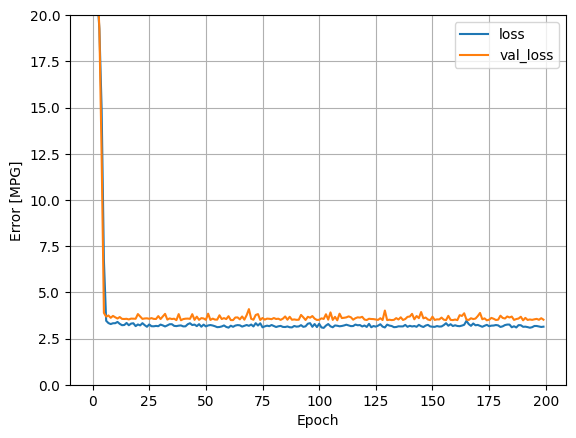

In [36]:
plot_loss(history)

Plotting the predictions as a function of `Horsepower`, we now see this model takes advantage of the nonlinearity provided by the hidden layers.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


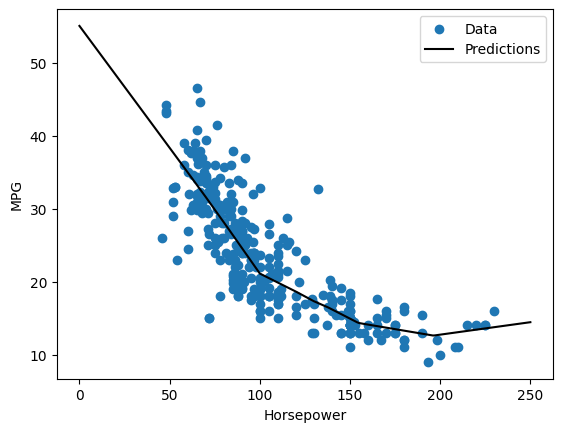

In [37]:
x = tf.linspace(0.0, 250, 251)
y = nn_horsepower_model.predict(x)

plot_horsepower(x, y)

We collect the results of the test set, for later comparison.

In [38]:
test_results['nn_horsepower_model'] = nn_horsepower_model.evaluate(
    X_test['Horsepower'], y_test,
    verbose=0)

This process can be repeated using all the inputs, which slightly improves the performance on the validation dataset.

In [56]:
nn_model = build_model_regress(normalizer, n_hidden=2, n_neurons=64,
                          learning_rate=0.03)
nn_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [40]:
%%time
history = nn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 12.6 s, sys: 579 ms, total: 13.2 s
Wall time: 15.2 s


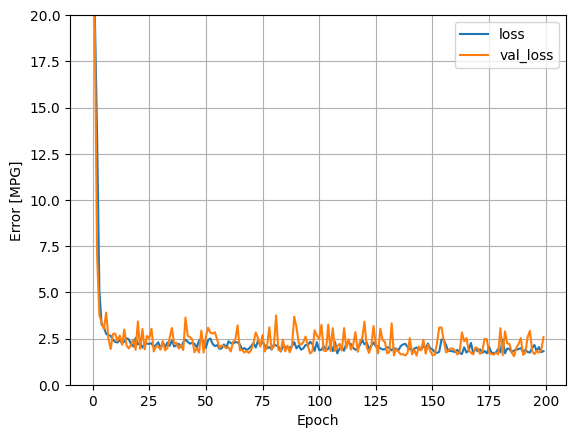

In [41]:
plot_loss(history)

Again we collect the results on the test set.

In [42]:
test_results['nn_model'] = nn_model.evaluate(X_test, y_test, verbose=0)

## Performance

Now that all the models are trained we can compare the performance. Not surprisingly, as the complexity of the model increases the absolute error of the model decrease. This suggests that the final model does not have excessive overfitting.

In [43]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
lin_horsepower_model,3.68
lin_model,2.46
nn_horsepower_model,3.26
nn_model,2.17


Finally, we can use `predict` to compare the predicted values for the testing set against the actual values.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


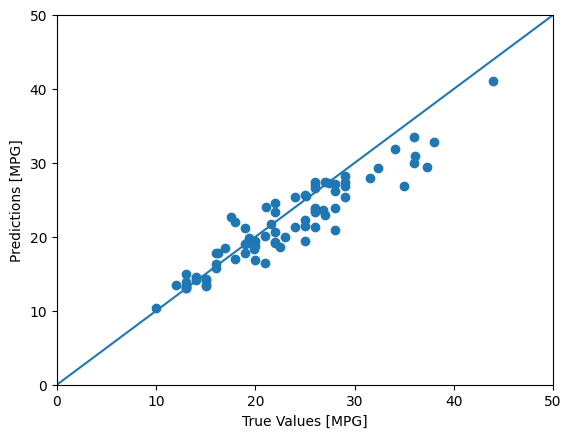

In [44]:
test_predictions = nn_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims,lims);

This suggests the model predicts the fuel efficiency reasonably well, so we can save it for later use.


In [45]:
nn_model.save('nn_model.keras');

## Exercises

### Exercise 1 (4 marks)

Create a neural network with the same parameters as `nn_model`, but using the sigmoid activation function (you will need to read the keras documention). Train the model, plot the history and store the model results in `test_results`.

In [61]:
def build_model_regress_sigmoid(norm, n_hidden=1, n_neurons=30, regress_activation="sigmoid",
                            learning_rate=0.01):
  """Build and compile a simple sequential model with n_hidden
  layers and n_neurons in each layer."""

  model = keras.models.Sequential()
  model.add(norm)
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation=regress_activation))
  model.add(keras.layers.Dense(1))

  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='mean_absolute_error', optimizer=optimizer)

  return model

nn_model1 = build_model_regress_sigmoid(normalizer, n_hidden=2, n_neurons=64,
                          learning_rate=0.03)
nn_model1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [63]:
%%time
history1 = nn_model1.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 12.9 s, sys: 542 ms, total: 13.4 s
Wall time: 15.4 s


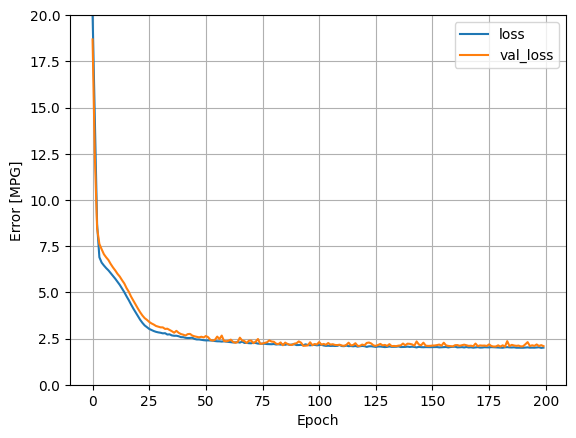

In [65]:
plot_loss(history1)

In [66]:
test_results['nn_model1'] = nn_model1.evaluate(X_test, y_test, verbose=0)

### Exercise 2 (4 marks)

Repeat Exercise 1, but this time use the ReLU activation function, with 4 hidden layers and 32 neurons in each layer.

In [53]:
nn_model2 = build_model_regress(normalizer, n_hidden=4, n_neurons=32,
                          learning_rate=0.03)
nn_model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [67]:
%%time
history2 = nn_model2.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 14.4 s, sys: 576 ms, total: 15 s
Wall time: 20.1 s


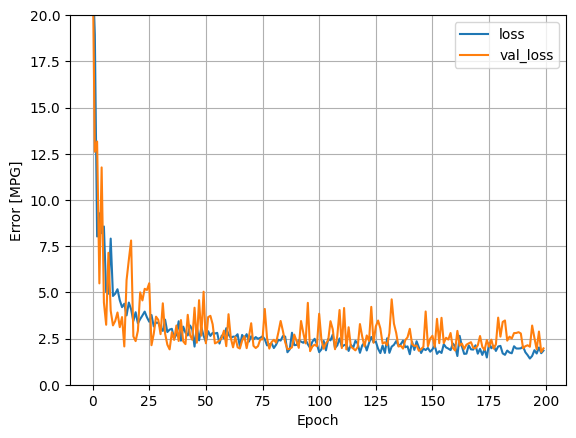

In [69]:
plot_loss(history2)

In [71]:
test_results['nn_model2'] = nn_model2.evaluate(X_test, y_test, verbose=0)

### Exercise 3 (2 marks)

Print the comparison of all six models that have been created and comment on the effect of changing the activation function and the structure of the neural network.

In [74]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
lin_horsepower_model,3.68
lin_model,2.46
nn_horsepower_model,3.26
nn_model,2.17
nn_model1,2.03
nn_model2,1.98



When we switched the activation function from ReLU to sigmoid, the Mean Absolute Error (MAE) dropped from 2.17 to 2.03. This small improvement suggests that the sigmoid function worked well in this case, possibly because it handles non-linear patterns in the data better.

Next, when we added more layers and neurons to the network, the MAE decreased even further to 1.98. This shows that the more complex structure helped the model capture more detailed patterns in the data, making it the best-performing model out of all the ones we tested.